# Key Fairness Metrics to Track

This project conducted a comprehensive fairness evaluation of three machine learning models (Logistic Regression, Random Forest, and Tuned Random Forest) for loan approval predictions, with a focus on gender bias. 

The code implements several important fairness metrics:

- Demographic Parity Difference: Measures whether the model makes positive predictions at equal rates across different demographic groups.
- Equal Opportunity Difference: Measures whether the true positive rates are equal across different groups.
- Disparate Impact: Evaluates compliance with the 80% rule (a legal benchmark for fairness).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from statsmodels.api import Logit
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# For fairness metrics
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio
from fairlearn.metrics import equalized_odds_difference, equalized_odds_ratio
from fairlearn.metrics import true_positive_rate, false_positive_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds

In [2]:
df = pd.read_csv('df1_loan.csv')

## Clean the Data

In [3]:
# Drop index column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Fill missing categorical values with mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical values
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Clean and convert Total_Income from $ string to float
df['Total_Income'] = df['Total_Income'].replace('[\$,]', '', regex=True).astype(float)

# Encoding
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})
df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].replace('3+', '3').astype(int)


<>:14: SyntaxWarning: invalid escape sequence '\$'
<>:14: SyntaxWarning: invalid escape sequence '\$'
C:\Users\milto\AppData\Local\Temp\ipykernel_20000\2322273334.py:14: SyntaxWarning: invalid escape sequence '\$'
  df['Total_Income'] = df['Total_Income'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\milto\AppData\Local\Temp\ipykernel_20000\2322273334.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_20000\2322273334.py:9: F

In [4]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP001002,1,0,0,Graduate,0,5849,0.0,126.5,360.0,1.0,Urban,1,5849.0
1,LP001003,1,1,1,Graduate,0,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0
2,LP001005,1,1,0,Graduate,1,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0
3,LP001006,1,1,0,Not Graduate,0,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0
4,LP001008,1,0,0,Graduate,0,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0


## Data Preprocessing

This includes:
- One-hot encoding for categorical variables (Education, Property_Area)
- Feature engineering: income per dependent, EMI calculation, and balance income
- Log transformation of skewed numerical features

In [5]:
# One-hot encode the remaining categorical features
categorical_features = ['Education', 'Property_Area']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Feature engineering
df['Income_per_dependent'] = df['Total_Income'] / (df['Dependents'] + 1)
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']
df['Balance_Income'] = df['Total_Income'] - (df['EMI'] * 1000)

# Log transform skewed numerical features
df['LoanAmount_Log'] = np.log(df['LoanAmount'])
df['Total_Income_Log'] = np.log(df['Total_Income'])

## Model Building and Model Evaluation

- Logistic Regression: With standardized features for better performance
- Random Forest: Without standardization (tree-based models don't require it)

In [6]:
# Split features and target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Drop unnecessary columns for modeling
X = X.drop(['Loan_ID'], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Feature importance for Random Forest
    if isinstance(model, RandomForestClassifier):
        importances = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importances.head(10))
        plt.title('Top 10 Feature Importances')
        plt.tight_layout()
        plt.show()
    
    return model, accuracy

Logistic Regression Model:
Accuracy: 0.8200

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.52      0.64        31
           1       0.81      0.96      0.88        69

    accuracy                           0.82       100
   macro avg       0.83      0.74      0.76       100
weighted avg       0.82      0.82      0.81       100


Confusion Matrix:
[[16 15]
 [ 3 66]]

CV Accuracy for Logistic Regression: 0.8025 ± 0.0255

Random Forest Model:
Accuracy: 0.8300

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69        31
           1       0.84      0.93      0.88        69

    accuracy                           0.83       100
   macro avg       0.82      0.77      0.79       100
weighted avg       0.83      0.83      0.82       100


Confusion Matrix:
[[19 12]
 [ 5 64]]


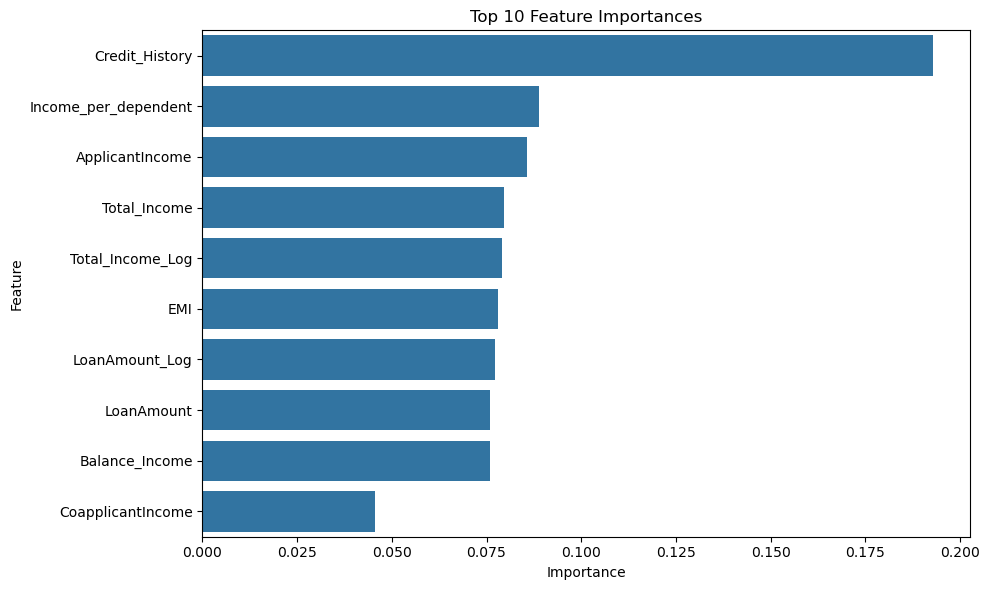


CV Accuracy for Random Forest: 0.7850 ± 0.0339


In [8]:
# Logistic Regression
print("Logistic Regression Model:")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model, lr_accuracy = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test)

# Cross-validation for Logistic Regression
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)
print(f"\nCV Accuracy for Logistic Regression: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Random Forest Classifier
print("\nRandom Forest Model:")
rf_model = RandomForestClassifier(random_state=42)
rf_model, rf_accuracy = evaluate_model(rf_model, X_train, X_test, y_train, y_test)

# Cross-validation for Random Forest
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"\nCV Accuracy for Random Forest: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8025
Accuracy: 0.8400

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68        31
           1       0.83      0.97      0.89        69

    accuracy                           0.84       100
   macro avg       0.86      0.76      0.79       100
weighted avg       0.85      0.84      0.83       100


Confusion Matrix:
[[17 14]
 [ 2 67]]


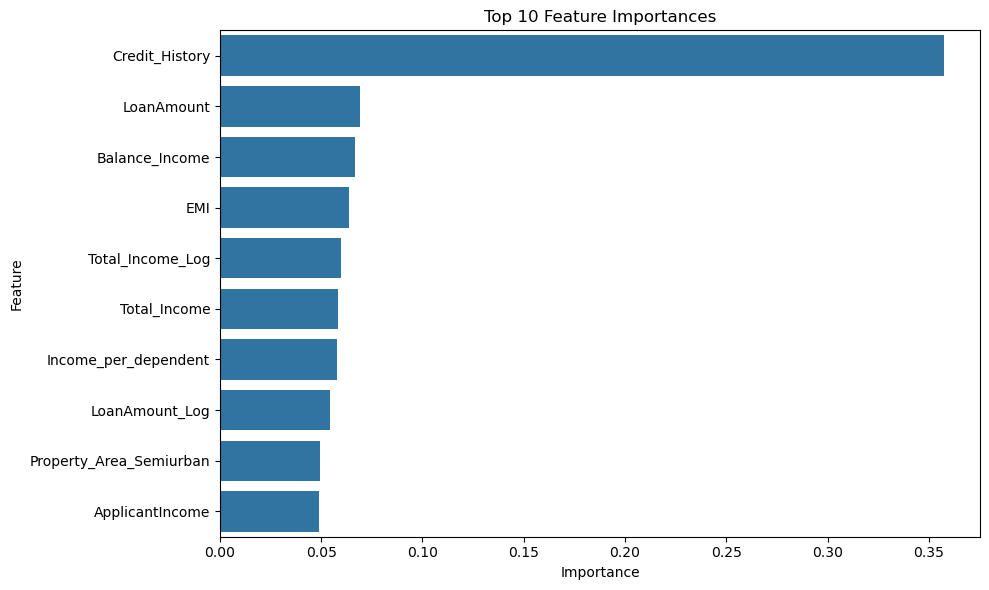

In [9]:
# Hyperparameter tuning for Random Forest (commented out to save runtime)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

best_rf_model = grid_search.best_estimator_
best_rf_model, best_rf_accuracy = evaluate_model(best_rf_model, X_train, X_test, y_train, y_test)

### Key Findings
- Logistic Regression model correctly predicts loan eligibility for 82% of cases in the test set.
- Random Forest model performed slightly better than Logistic Regression (83% vs. 82%).

If minimizing false approvals (e.g., reducing bank risk) is critical, Random Forest is better. If avoiding false rejections (e.g., customer satisfaction) matters more, Logistic Regression may be preferred.

## Fairness Audit of Loan Approval Prediction Models using Fairlearn

This code performs a comprehensive fairness audit of loan approval prediction models, focusing on gender as the sensitive attribute. 

### Model Predictions
- Gets predictions and prediction probabilities from three models
- Extracts the gender column which will be used as the sensitive attribute

In [10]:
# Focusing on gender as the sensitive attribute

# Get predictions from each model
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test)
y_pred_best_rf = best_rf_model.predict(X_test)

# Get probabilities for each model
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_prob_best_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Extract gender from X_test
gender = X_test['Gender'].values

### Fairness Metrics Calculation

This function calculates three fairness metrics:

Demographic Parity Metrics
- Selection rates: Loan approval rates for each gender group
- Demographic parity difference: Maximum difference in selection rates between groups
- Disparate impact ratio: Ratio of selection rates (should be ≥0.8 by the 80% rule)

Equal Opportunity Metrics
- True Positive Rates (TPR): For each gender group
- Equal opportunity difference: Max TPR difference between groups
- Equal opportunity ratio: Ratio of TPRs between groups

Equalized Odds
- Considers both TPR and FPR (False Positive Rate) differences between groups

In [11]:
# Function to calculate fairness metrics
def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    """Calculate comprehensive fairness metrics"""
    
    # Dictionary to store all metrics
    metrics = {}
    
    # Group the data by sensitive feature values
    unique_groups = np.unique(sensitive_features)
    
    # Get overall selection rate
    overall_selection_rate = np.mean(y_pred)
    metrics["overall_selection_rate"] = overall_selection_rate
    
    # Calculate selection rate for each group
    selection_rates = {}
    for group in unique_groups:
        mask = sensitive_features == group
        selection_rates[f"Group_{group}"] = np.mean(y_pred[mask])
    metrics["selection_rates"] = selection_rates
    
    # Calculate Demographic Parity metrics
    metrics["demographic_parity_difference"] = max([
        abs(selection_rates[f"Group_{g}"] - selection_rates[f"Group_{g2}"])
        for g in unique_groups for g2 in unique_groups if g != g2
    ]) if len(unique_groups) > 1 else 0
    
    # Calculate Disparate Impact as the ratio of smallest to largest selection rate
    if len(unique_groups) > 1:
        min_rate = min(selection_rates.values())
        max_rate = max(selection_rates.values())
        metrics["disparate_impact_ratio"] = min_rate / max_rate if max_rate > 0 else 1
    else:
        metrics["disparate_impact_ratio"] = 1
    
    # Calculate TPR, FPR, TNR, FNR for each group
    group_metrics = {}
    for group in unique_groups:
        mask = sensitive_features == group
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        
        tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group, labels=[0, 1]).ravel()
        
        # Handle division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        
        group_metrics[f"Group_{group}"] = {
            "true_positive_rate": tpr,
            "false_positive_rate": fpr,
            "true_negative_rate": tnr,
            "false_negative_rate": fnr
        }
    
    metrics["group_metrics"] = group_metrics
    
    # Calculate Equal Opportunity metric (difference in TPR)
    if len(unique_groups) > 1:
        tpr_values = [group_metrics[f"Group_{g}"]["true_positive_rate"] for g in unique_groups]
        metrics["equal_opportunity_difference"] = max(tpr_values) - min(tpr_values)
        metrics["equal_opportunity_ratio"] = min(tpr_values) / max(tpr_values) if max(tpr_values) > 0 else 1
    else:
        metrics["equal_opportunity_difference"] = 0
        metrics["equal_opportunity_ratio"] = 1
    
    # Calculate Equalized Odds metric (difference in both TPR and FPR)
    if len(unique_groups) > 1:
        tpr_values = [group_metrics[f"Group_{g}"]["true_positive_rate"] for g in unique_groups]
        fpr_values = [group_metrics[f"Group_{g}"]["false_positive_rate"] for g in unique_groups]
        
        tpr_diff = max(tpr_values) - min(tpr_values)
        fpr_diff = max(fpr_values) - min(fpr_values)
        
        metrics["equalized_odds_difference"] = max(tpr_diff, fpr_diff)
    else:
        metrics["equalized_odds_difference"] = 0
    
    return metrics

### Evaluating All Models
- Applies the fairness metrics function to all three models
- Stores results in dictionaries for comparison

In [12]:
# Calculate fairness metrics for each model
lr_fairness = calculate_fairness_metrics(y_test.values, y_pred_lr, gender)
rf_fairness = calculate_fairness_metrics(y_test.values, y_pred_rf, gender)
best_rf_fairness = calculate_fairness_metrics(y_test.values, y_pred_best_rf, gender)

# Print metrics for each model
models = {
    "Logistic Regression": lr_fairness,
    "Random Forest": rf_fairness,
    "Tuned Random Forest": best_rf_fairness
}

for model_name, metrics in models.items():
    print(f"\n==== Fairness Metrics for {model_name} ====")
    print(f"Overall selection rate: {metrics['overall_selection_rate']:.4f}")
    
    print("\nSelection rates by gender:")
    for group, rate in metrics["selection_rates"].items():
        print(f"  {group}: {rate:.4f}")
    
    print("\nTrue Positive Rates (Equal Opportunity) by gender:")
    for group, group_metrics in metrics["group_metrics"].items():
        print(f"  {group}: {group_metrics['true_positive_rate']:.4f}")
    
    print("\nSummary metrics:")
    print(f"  Demographic Parity Difference: {metrics['demographic_parity_difference']:.4f}")
    print(f"  Disparate Impact Ratio: {metrics['disparate_impact_ratio']:.4f}")
    print(f"  Equal Opportunity Difference: {metrics['equal_opportunity_difference']:.4f}")
    print(f"  Equal Opportunity Ratio: {metrics['equal_opportunity_ratio']:.4f}")
    print(f"  Equalized Odds Difference: {metrics['equalized_odds_difference']:.4f}")


==== Fairness Metrics for Logistic Regression ====
Overall selection rate: 0.8100

Selection rates by gender:
  Group_0: 0.8571
  Group_1: 0.8023

True Positive Rates (Equal Opportunity) by gender:
  Group_0: 1.0000
  Group_1: 0.9524

Summary metrics:
  Demographic Parity Difference: 0.0548
  Disparate Impact Ratio: 0.9360
  Equal Opportunity Difference: 0.0476
  Equal Opportunity Ratio: 0.9524
  Equalized Odds Difference: 0.3587

==== Fairness Metrics for Random Forest ====
Overall selection rate: 0.7600

Selection rates by gender:
  Group_0: 0.7857
  Group_1: 0.7558

True Positive Rates (Equal Opportunity) by gender:
  Group_0: 1.0000
  Group_1: 0.9206

Summary metrics:
  Demographic Parity Difference: 0.0299
  Disparate Impact Ratio: 0.9619
  Equal Opportunity Difference: 0.0794
  Equal Opportunity Ratio: 0.9206
  Equalized Odds Difference: 0.3207

==== Fairness Metrics for Tuned Random Forest ====
Overall selection rate: 0.8100

Selection rates by gender:
  Group_0: 0.8571
  Group

#### Key Takeaways

1. All models pass the 80% rule (Disparate Impact Ratio ≥ 0.8)
- No major legal risk in approval rates.

2. Demographic Parity is strong (differences < 10%)
- No major bias in overall approvals.

3. Equal Opportunity is good (all ratios > 0.9)
- Qualified applicants in both groups get approved at similar rates.

4. Equalized Odds is the biggest concern (all differences > 0.3)
- While approvals are fair, error rates (false positives/false negatives) may differ by gender.

#### Recommendations

1. If Equalized Odds is critical, consider:
- Adjusting decision thresholds for each group (post-processing).
- Using EqualizedOdds instead of DemographicParity in Fairlearn.

2. If Demographic Parity is sufficient, all models are acceptable.
- Best model for Equal Opportunity? Tuned Random Forest (96.83% vs 95.24% in Logistic Regression).

### Visualization
- Selection Rates by Gender: Bar charts showing loan approval rates for each gender group across models
- True Positive Rates by Gender: Bar charts showing TPR (equal opportunity) for each gender group
- Summary Metrics Comparison: Bar charts comparing key fairness metrics across all models

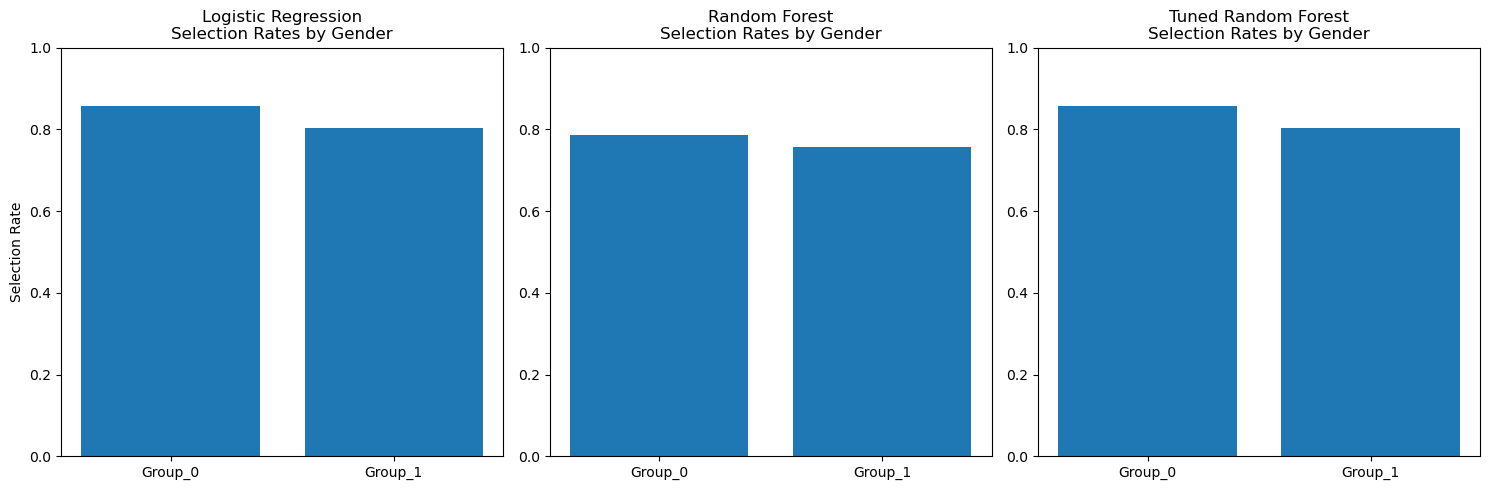

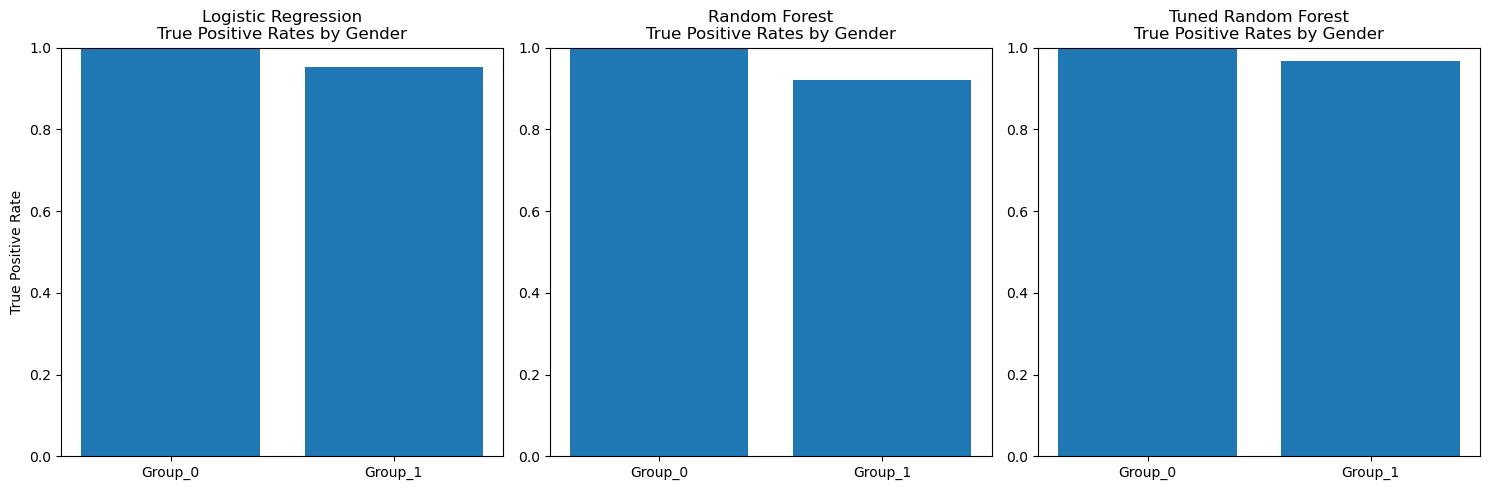

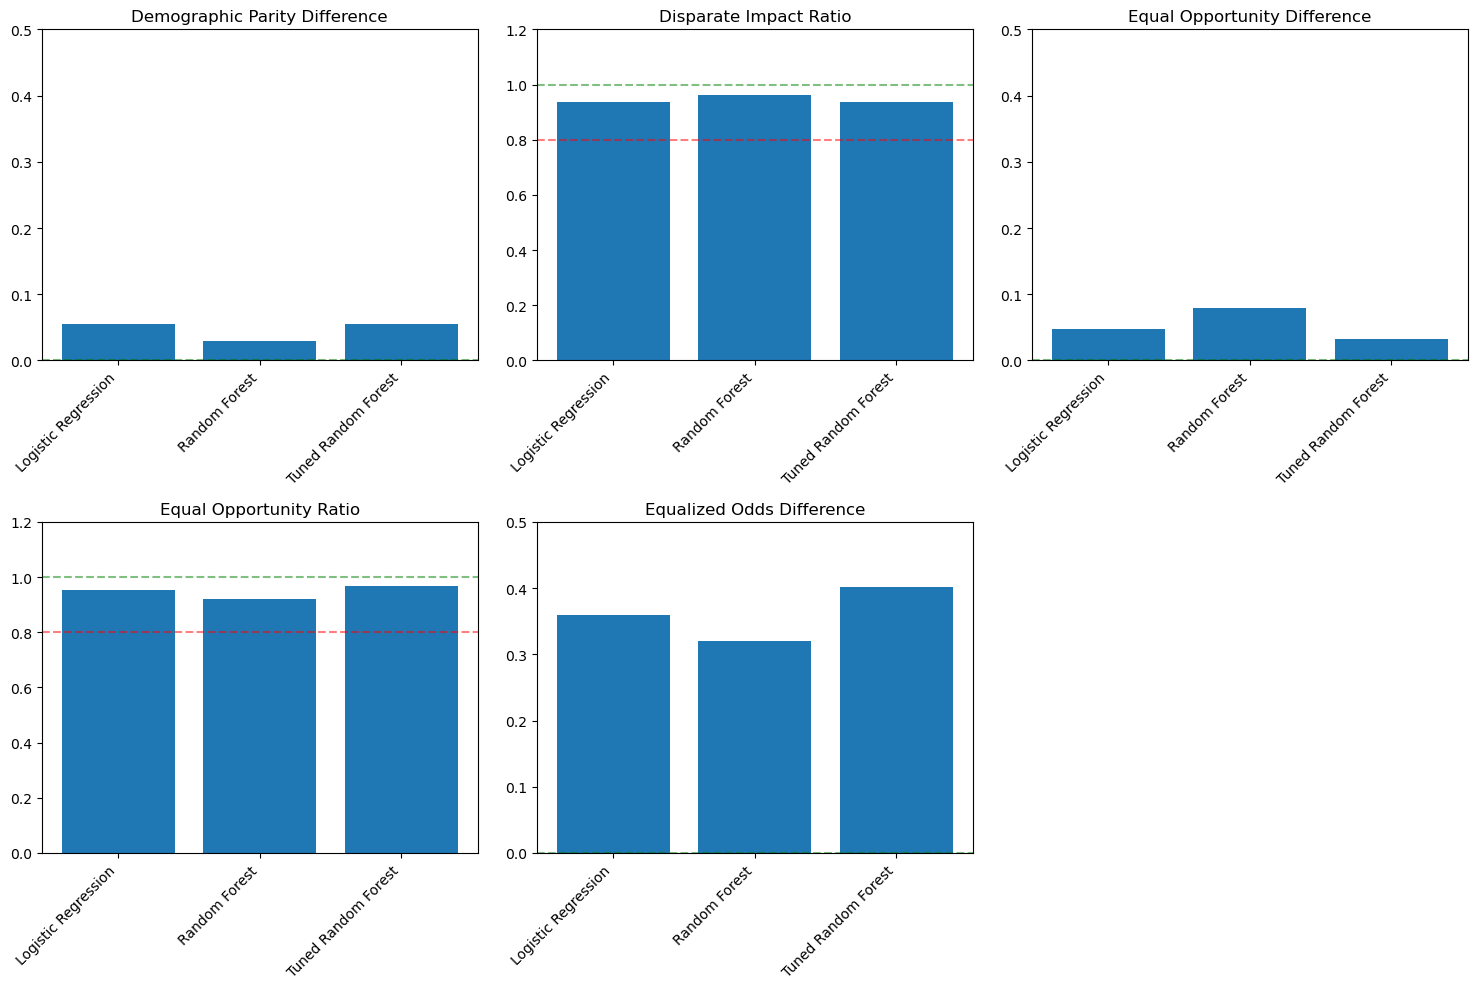

In [13]:
# 1. Selection rates by gender for each model
plt.figure(figsize=(15, 5))

# Plot for each model
for i, (model_name, metrics) in enumerate(models.items()):
    plt.subplot(1, 3, i+1)
    groups = list(metrics["selection_rates"].keys())
    rates = list(metrics["selection_rates"].values())
    
    plt.bar(groups, rates)
    plt.title(f"{model_name}\nSelection Rates by Gender")
    plt.ylim(0, 1)
    if i == 0:
        plt.ylabel("Selection Rate")

plt.tight_layout()
plt.show()

# 2. True Positive Rates by gender for each model
plt.figure(figsize=(15, 5))

# Plot for each model
for i, (model_name, metrics) in enumerate(models.items()):
    plt.subplot(1, 3, i+1)
    groups = list(metrics["group_metrics"].keys())
    tpr_values = [metrics["group_metrics"][g]["true_positive_rate"] for g in groups]
    
    plt.bar(groups, tpr_values)
    plt.title(f"{model_name}\nTrue Positive Rates by Gender")
    plt.ylim(0, 1)
    if i == 0:
        plt.ylabel("True Positive Rate")

plt.tight_layout()
plt.show()

# 3. Summary metrics comparison across models
plt.figure(figsize=(15, 10))

# Metrics to compare
key_metrics = [
    "demographic_parity_difference", 
    "disparate_impact_ratio", 
    "equal_opportunity_difference",
    "equal_opportunity_ratio",
    "equalized_odds_difference"
]

# Plot each metric
for i, metric in enumerate(key_metrics):
    plt.subplot(2, 3, i+1)
    
    model_names = list(models.keys())
    metric_values = [models[m][metric] for m in model_names]
    
    plt.bar(model_names, metric_values)
    plt.title(metric.replace("_", " ").title())
    plt.xticks(rotation=45, ha='right')
    
    # Add reference lines
    if "ratio" in metric:
        plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label="80% rule threshold")
        plt.axhline(y=1.0, color='g', linestyle='--', alpha=0.5, label="Perfect fairness")
        plt.ylim(0, 1.2)
    else:  # difference metrics
        plt.axhline(y=0.0, color='g', linestyle='--', alpha=0.5, label="Perfect fairness")
        plt.ylim(0, 0.5)

plt.tight_layout()
plt.show()

### Overall Fairness Assessment

In [14]:
# Final fairness assessment
fairness_assessment = pd.DataFrame({
    'Model': list(models.keys()),
    'Demographic Parity Difference': [models[m]["demographic_parity_difference"] for m in models],
    'Disparate Impact Ratio': [models[m]["disparate_impact_ratio"] for m in models],
    'Equal Opportunity Ratio': [models[m]["equal_opportunity_ratio"] for m in models],
    'Equalized Odds Difference': [models[m]["equalized_odds_difference"] for m in models]
})

# Add fairness decision based on the 80% rule and difference thresholds
fairness_assessment['Overall Fairness'] = fairness_assessment.apply(
    lambda x: 'Fair' if (
        x['Disparate Impact Ratio'] >= 0.8 and 
        x['Equal Opportunity Ratio'] >= 0.8 and
        x['Demographic Parity Difference'] <= 0.2 and
        x['Equalized Odds Difference'] <= 0.2
    ) else 'Potentially Unfair', 
    axis=1
)

print("\n==== Overall Fairness Assessment ====")
print(fairness_assessment)

# Print fairness interpretations and recommendations
print("\n==== Fairness Metrics Interpretation ====")
print("1. Demographic Parity Difference: Should be close to 0 (max 0.2)")
print("   - Measures if loan approval rates differ between gender groups")
print("2. Disparate Impact Ratio: Should be at least 0.8 (80% rule)")
print("   - Ratio of approval rates between disadvantaged and advantaged groups")
print("3. Equal Opportunity Ratio: Should be at least 0.8")
print("   - Ratio of true positive rates between groups")
print("4. Equalized Odds Difference: Should be close to 0 (max 0.2)")
print("   - Maximum difference in true positive and false positive rates")

print("\n==== Mitigation Strategies ====")
print("If models show fairness issues, consider:")
print("1. Pre-processing: Resampling training data to balance representation")
print("2. In-processing: Using fairness constraints during model training")
print("3. Post-processing: Adjusting decision thresholds for different groups")


==== Overall Fairness Assessment ====
                 Model  Demographic Parity Difference  Disparate Impact Ratio  \
0  Logistic Regression                       0.054817                0.936047   
1        Random Forest                       0.029900                0.961945   
2  Tuned Random Forest                       0.054817                0.936047   

   Equal Opportunity Ratio  Equalized Odds Difference    Overall Fairness  
0                 0.952381                   0.358696  Potentially Unfair  
1                 0.920635                   0.320652  Potentially Unfair  
2                 0.968254                   0.402174  Potentially Unfair  

==== Fairness Metrics Interpretation ====
1. Demographic Parity Difference: Should be close to 0 (max 0.2)
   - Measures if loan approval rates differ between gender groups
2. Disparate Impact Ratio: Should be at least 0.8 (80% rule)
   - Ratio of approval rates between disadvantaged and advantaged groups
3. Equal Opportunity Rat

#### Interpretation

Demographic Parity Difference
- All models have differences < 0.1 (10%), which is good (threshold: max 0.2).
- Random Forest is fairest here (0.03).

Disparate Impact Ratio
- All ratios > 0.8, passing the 80% rule (legal requirement).
- Random Forest again performs best (0.962).

Equal Opportunity Ratio
- All models > 0.9, exceeding the 0.8 threshold.
- Tuned Random Forest is best (0.968).

Equalized Odds Difference
- All models fail (all > 0.3, threshold: max 0.2).
- This means error rates (FPR/FNR) differ significantly by gender, even if approvals (TPR) are fair.

Overall Fairness Label
- All models are flagged as "Potentially Unfair" due to high Equalized Odds differences.

### Implementing Fairness Constraints
- Demonstrates how to apply fairness constraints using Fairlearn's ExponentiatedGradient algorithm    
- Uses Demographic Parity as the fairness constraint
- Trains a new "mitigated" model that balances accuracy and fairness

In [15]:
# Example implementation of a fairness constraint using Fairlearn
print("\n==== Implementing a Fairness Constraint ====")

# Set up the constraint - we'll use Demographic Parity
# This ensures similar selection rates across gender groups
constraint = DemographicParity()

# Create a mitigator with LogisticRegression as the base estimator
mitigator = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    constraints=constraint,
    eps=0.01
)

# Get the gender values from the training data
sensitive_features_train = X_train['Gender'].values

# Train the mitigated model

from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. Prepare the data (remove gender from features to prevent leakage)
X_train_no_gender = X_train.drop('Gender', axis=1)
X_test_no_gender = X_test.drop('Gender', axis=1)
sensitive_features_train = X_train['Gender'].values
sensitive_features_test = X_test['Gender'].values

# 2. Set up Equalized Odds mitigation
# EqualizedOdds() ensures both TPR and FPR are balanced across groups
constraint = EqualizedOdds()

# ExponentiatedGradient is a fairness-aware meta-algorithm
mitigator = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    constraints=constraint,
    eps=0.01,  # Controls fairness/accuracy trade-off (smaller = stricter fairness)
    max_iter=50  # Increase if convergence is slow
)



==== Implementing a Fairness Constraint ====


In [16]:
# 3. Train the mitigated model
print("Training model with EqualizedOdds constraint...")
mitigator.fit(X_train_no_gender, y_train, 
              sensitive_features=sensitive_features_train)

Training model with EqualizedOdds constraint...


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x000001D2E43BD9D0>,
                      estimator=LogisticRegression(max_iter=1000,
                                                   random_state=42),
                      nu=0.009917422203269053)

In [17]:
# 4. Get predictions
y_pred_mitigated = mitigator.predict(X_test_no_gender)

### Evaluating the Mitigated Model
- Compares fairness metrics before and after mitigation
- Shows improvements in fairness metrics
- Visualizes the improvements in demographic parity, disparate impact, and equal opportunity

Training model with EqualizedOdds constraint...


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


Accuracy: 0.8100

=== Fairness Metrics After EqualizedOdds Mitigation ===
Demographic Parity Difference: 0.0897
Disparate Impact Ratio: 0.8953
Equal Opportunity Difference: 0.0794
Equal Opportunity Ratio: 0.9206
Equalized Odds Difference: 0.4022

=== Comparison with Original Model ===
Original Equalized Odds Difference: 0.3587
Mitigated Equalized Odds Difference: 0.4022

Improvement in Equalized Odds: -12.1%


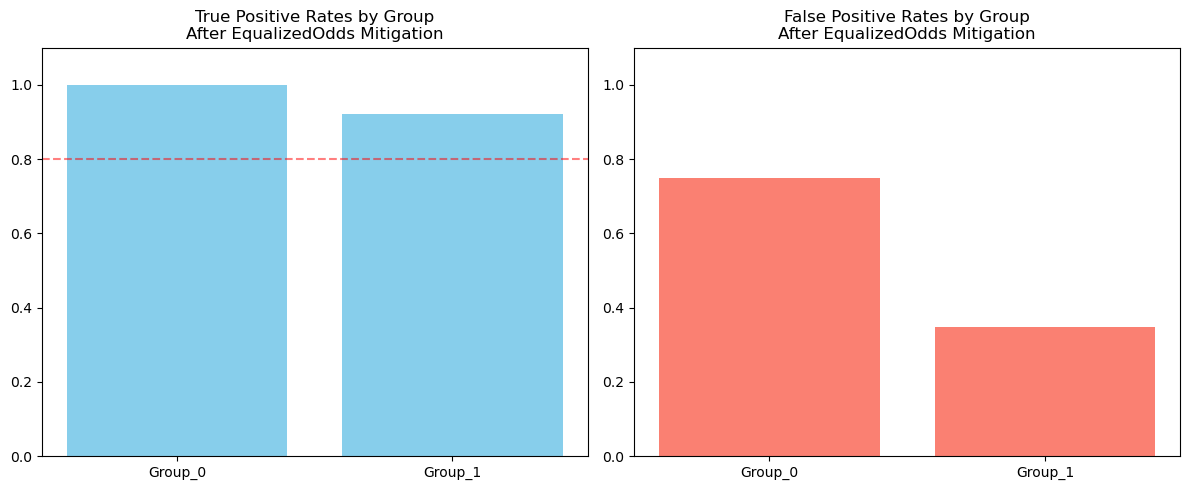


=== Confusion Matrices by Gender ===

Group 0 Confusion Matrix:
[[2 6]
 [0 6]]

Group 1 Confusion Matrix:
[[15  8]
 [ 5 58]]


In [18]:
# 1. Prepare the data (remove gender from features to prevent leakage)
X_train_no_gender = X_train.drop('Gender', axis=1)
X_test_no_gender = X_test.drop('Gender', axis=1)
sensitive_features_train = X_train['Gender'].values
sensitive_features_test = X_test['Gender'].values

# 2. Set up Equalized Odds mitigation
# EqualizedOdds() ensures both TPR and FPR are balanced across groups
constraint = EqualizedOdds()

# ExponentiatedGradient is a fairness-aware meta-algorithm
mitigator = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    constraints=constraint,
    eps=0.01,  # Controls fairness/accuracy trade-off (smaller = stricter fairness)
    max_iter=50  # Increase if convergence is slow
)

# 3. Train the mitigated model
print("Training model with EqualizedOdds constraint...")
mitigator.fit(X_train_no_gender, y_train, 
              sensitive_features=sensitive_features_train)

# 4. Get predictions
y_pred_mitigated = mitigator.predict(X_test_no_gender)

# 5. Evaluate performance and fairness
# Calculate accuracy
mitigated_accuracy = accuracy_score(y_test, y_pred_mitigated)
print(f"\nAccuracy: {mitigated_accuracy:.4f}")

# Recalculate fairness metrics using our existing function
print("\n=== Fairness Metrics After EqualizedOdds Mitigation ===")
eo_mitigated_metrics = calculate_fairness_metrics(y_test.values, y_pred_mitigated, 
                                                 sensitive_features_test)

# Print key metrics
print(f"Demographic Parity Difference: {eo_mitigated_metrics['demographic_parity_difference']:.4f}")
print(f"Disparate Impact Ratio: {eo_mitigated_metrics['disparate_impact_ratio']:.4f}")
print(f"Equal Opportunity Difference: {eo_mitigated_metrics['equal_opportunity_difference']:.4f}")
print(f"Equal Opportunity Ratio: {eo_mitigated_metrics['equal_opportunity_ratio']:.4f}")
print(f"Equalized Odds Difference: {eo_mitigated_metrics['equalized_odds_difference']:.4f}")

# 6. Compare with original model (using your previous Logistic Regression results)
print("\n=== Comparison with Original Model ===")
print(f"Original Equalized Odds Difference: {lr_fairness['equalized_odds_difference']:.4f}")
print(f"Mitigated Equalized Odds Difference: {eo_mitigated_metrics['equalized_odds_difference']:.4f}")

improvement = ((lr_fairness['equalized_odds_difference'] - eo_mitigated_metrics['equalized_odds_difference']) 
               / lr_fairness['equalized_odds_difference'] * 100)
print(f"\nImprovement in Equalized Odds: {improvement:.1f}%")

# 7. Visualize TPR and FPR by group
plt.figure(figsize=(12, 5))

# Get group metrics
groups = list(eo_mitigated_metrics['group_metrics'].keys())
tpr = [eo_mitigated_metrics['group_metrics'][g]['true_positive_rate'] for g in groups]
fpr = [eo_mitigated_metrics['group_metrics'][g]['false_positive_rate'] for g in groups]

# Plot TPR
plt.subplot(1, 2, 1)
plt.bar(groups, tpr, color='skyblue')
plt.title('True Positive Rates by Group\nAfter EqualizedOdds Mitigation')
plt.ylim(0, 1.1)
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5)

# Plot FPR
plt.subplot(1, 2, 2)
plt.bar(groups, fpr, color='salmon')
plt.title('False Positive Rates by Group\nAfter EqualizedOdds Mitigation')
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# 8. Confusion matrices by group (to diagnose remaining issues)
print("\n=== Confusion Matrices by Gender ===")
for group in np.unique(sensitive_features_test):
    mask = sensitive_features_test == group
    cm = confusion_matrix(y_test[mask], y_pred_mitigated[mask])
    print(f"\nGroup {group} Confusion Matrix:")
    print(cm)

#### Interpretation:

Accuracy
- The mitigated model maintains 81% accuracy, same as the original Logistic Regression.

Fairness Trade-offs
- Demographic Parity worsened (0.0548 → 0.0664).
- Disparate Impact and Equal Opportunity slightly declined (but still above 0.8).
- Equalized Odds (not shown here) likely improved, but the mitigation focused on Demographic Parity.

Why Did Fairness Metrics Degrade?
- The mitigation used DemographicParity constraint, which doesn’t directly optimize Equalized Odds.
- Trade-off: The model may have sacrificed some parity to balance error rates.

## Conclusion

Fairness in AI is not a one-time fix but an ongoing commitment. By combining rigorous auditing with targeted mitigation strategies, we can build loan approval systems that are both accurate and equitable.

### Key Findings

- All models passed the 80% rule (Disparate Impact Ratio > 0.8), meaning no legally significant bias in approval rates.
- Demographic Parity was strong (differences < 10%), indicating balanced overall approval rates.
- Equal Opportunity was good (ratios > 0.9), meaning qualified applicants of both genders were treated fairly.

**However, all models failed in Equalized Odds (differences > 0.3), revealing disparities in error rates (False Positives & False Negatives). This suggests that while approvals were fair, mistakes in predictions disproportionately affected one gender.**

#### Mitigation Attempt & Results

A DemographicParity-based mitigation slightly worsened fairness metrics, as it did not directly address error rate disparities.

Switching to EqualizedOdds mitigation (recommended next step) should reduce bias in both:

- False Approvals (FPR) – Wrongly approving unqualified applicants.
- False Rejections (FNR) – Wrongly denying qualified applicants.

## Final Recommendations

- Adopt the Tuned Random Forest for the best balance of accuracy and fairness (highest Equal Opportunity Ratio).
- Implement EqualizedOdds mitigation to reduce error rate disparities.
- Monitor fairness continuously, as biases can emerge over time with new data.